# Sentiment Analysis

## Imports

In [275]:
# pandas library and other Python modules
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from os import chdir
from os.path import isfile, join
from random import shuffle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score

import numpy as np # linear algebra
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from scipy.stats import uniform
from scipy.sparse import csr_matrix

## Data Preparation

Here, what we have are tweets. I will be considering each tweet as a document.
Let's follow the following steps:
- Read the cached CSV
- Take the polarity, sensetivity, and text columns
- split into train and test set

In [40]:
#data loader class
class DataLoader:
    def __init__(self,dir_name,file_name):
        self.dir_name = dir_name
        self.file_name = file_name


    def read_csv(self):
        chdir(self.dir_name)
        tweets_df = pd.read_csv(self.file_name)
        chdir("notebooks")
        return tweets_df

In [149]:
filename = 'processed_tweet_data.csv'
loader = DataLoader('../', filename)
df = loader.read_csv()
print(df.shape)
print(df.columns)

(24637, 15)
Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'possibly_sensitive', 'hashtags',
       'user_mentions', 'place'],
      dtype='object')


## Data Cleaner

In [211]:
class CleanTweets:
    """
    The PEP8 Standard AMAZING!!!
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df
        print('Automation in Action...!!!')

    def drop_unwanted_rows(self) -> pd.DataFrame:
        """
        remove rows that has column names. This error originated from
        the data collection stage.  
        """
        null_rows = self.df['polarity'].isna().tolist()
        self.df = self.df.drop(self.df[null_rows].index)
        self.df = self.df[~self.df['polarity'].isin(["ko", "en"])]


    def drop_duplicate(self) -> pd.DataFrame:
        """
        drop duplicate rows
        """
        self.df.drop_duplicates(inplace=True)

    def drop_null(self)->pd.DataFrame:
        # removed columns containing null values of more than 20%
        row,col = df.shape
        self.df.dropna(axis='columns',thresh=row*0.8,inplace=True)

    def convert_to_datetime(self) -> pd.DataFrame:
        """
        convert column to datetime
        """
        self.df['created_at'] = pd.to_datetime(self.df['created_at'])

    def convert_to_numbers(self, column_names=None) -> pd.DataFrame:
        """
        convert columns like polarity, subjectivity, retweet_count
        favorite_count etc to numbers
        """
        if not column_names:
            column_names = ['polarity', 'subjectivity',
                        'retweet_count', 'favorite_count',
                        'followers_count', 'friends_count']
        for column in column_names:
            self.df[column] = pd.to_numeric(self.df[column])

    def remove_non_english_tweets(self) -> pd.DataFrame:
        """
        remove non english tweets from lang
        """
        self.df = self.df[self.df['lang'] == 'en']

    def reset_index(self) -> pd.DataFrame:
        """
        reset the index after preprocessing
        """
        self.df.reset_index(drop=True, inplace=True)
    
    def special_chars(self, x):
        special_characters = '@_!#$%^&*()<>?/\|}{~:;[]'
        for char in special_characters:
            x = x.replace(char, '')
        x = x.encode('ascii', 'ignore').decode('ascii')
        
        return x
    
    def filter_text(self) -> pd.DataFrame:
        print(self.df.columns)
        self.df['clean_text'] = self.df['original_text'].apply(
            lambda x: self.special_chars(x))


    def clean_df(self):
        self.drop_null()
        self.drop_unwanted_rows()
        self.remove_non_english_tweets()
        self.drop_duplicate()
        self.convert_to_datetime()
        self.convert_to_numbers()
        self.reset_index()
        self.filter_text()

        return self.df


In [212]:
# df = tweets_df[['original_text', 'polarity', 'subjectivity', 'possibly_sensitive', 'lang']]
print(df.shape)
# df.head()

(24637, 15)


In [213]:
cleaner = CleanTweets(df)
cleaned_df = cleaner.clean_df()
cleaned_df.info()

Automation in Action...!!!
Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'hashtags', 'user_mentions'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16465 entries, 0 to 16464
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       16465 non-null  datetime64[ns, UTC]
 1   source           16465 non-null  object             
 2   original_text    16465 non-null  object             
 3   polarity         16465 non-null  float64            
 4   subjectivity     16465 non-null  float64            
 5   lang             16465 non-null  object             
 6   favorite_count   16465 non-null  int64              
 7   retweet_count    16465 non-null  float64            
 8   original_author  16465 non-null  object

In [214]:
cleaned_df = cleaned_df[['clean_text', 'polarity', 'subjectivity']]
cleaned_df.describe()

,polarity,subjectivity
count,16465.000000,16465.000000
mean,0.088542,0.313959
std,0.279757,0.316419
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.288889
75%,0.200000,0.527778
max,1.000000,1.000000


In [216]:
print("Null entry count per column")
cleaned_df.isnull().sum()

Null entry count per column


clean_text      0
polarity        0
subjectivity    0
dtype: int64

## Data Preparation

The data needs to be in an X -> Y format.
The X would be the clean_text and Y would be a label calculated 
from polarity and subjectivity

In [280]:
class SADataPreparation:
    """
    This class handles the labeld data creation for a Sentiment Analysis task
    It takes in a cleaned datafrane
    """
    def __init__(self,df):
        self.df = df

    def text_label(self, p)-> str:
        if p > 0 :
            return 'positive'
        elif p < 0 :
            return 'negative'
        else:
            return 'neutral'
  
  
    def preprocess_data(self, drop_neutral=True):
        score = self.df['polarity'].apply(
            lambda x: self.text_label(x))
        print(type(score))
        self.df['score'] = score
        if drop_neutral:
            neutrals = self.df[self.df['score'] == 'neutral']
            self.df = self.df.drop(neutrals.index)
        self.df = self.df.reset_index(drop=True)
        
        return self.df

    def prepare_features(self):
        self.preprocess_data()
        score_series = self.df['score'].map({'positive':1, 'negative':0})
        text_series = self.df['clean_text']
        X = text_series.tolist()
        y = score_series.tolist()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) 
        
        return X_train, X_test, y_train, y_test

    def vectorize_features(self):
        X_train, X_test, y_train, y_test = self.prepare_features()
        trigram_vect = CountVectorizer(ngram_range=(3, 3))
        trigram_vect.fit(X_train)
        X_train_trigram = trigram_vect.transform(X_train)
        X_test_trigram = trigram_vect.transform(X_test)
        
        return X_train_trigram, X_test_trigram, y_train, y_test, trigram_vect

In [266]:
# Get Vectorized Features
X_train_trigram, X_test_trigram, y_train, y_test, trigram_vect = SADataPreparation(cleaned_df).vectorize_features()

<class 'pandas.core.series.Series'>


/tmp/ipykernel_5637/577006742.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['score'] = score


In [267]:
## Modeling

In [276]:
class Modeling:
    def __init__(self,X_train,X_test,y_train,y_test,trigram_vect):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.trigram_vect = trigram_vect

    def model(self):
        clf = SGDClassifier()
        clf.fit(self.X_train, y_train)
        
        return clf

    def predict(self, x_test=None):
        sgd_model = self.model()
        if x_test is None:
            
            return sgd_model.predict(self.X_test)
        else:
            x_vect = self.trigram_vect.transform(x_test)
            
            return sgd_model.predict(x_vect)

    def display_info_model(self):
        print(self.model().show_topics(formatted=False))

    def score(self):
        train_score = clf.score(self.predict(self.X_train), self.y_train)
        test_score = clf.score(self.predict(self.X_test), self.y_test)
        print("Train score: "+str(round(train_score, 2))+" ; Validation score: "+str(round(test_score, 2)))

    def precision_recall(self):
        precision = precision_score(self.y_test, self.predict(), average='weighted')
        recall = recall_score(self.y_test, self.predict(), average='weighted')
        print(f'The precision score is {precision} and the recall score is {recall}')

There are lots of missing values in the sensitivity colum, so i will drop it

In [277]:
model_output = Modeling(X_train_trigram,X_test_trigram,y_train, y_test,trigram_vect)
model_output.predict()[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [278]:
model_output.precision_recall()

The precision score is 0.816710884952448 and the recall score is 0.7611111111111111


<class 'pandas.core.series.Series'>


/tmp/ipykernel_5637/2590083492.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['score'] = score


<AxesSubplot:ylabel='score'>

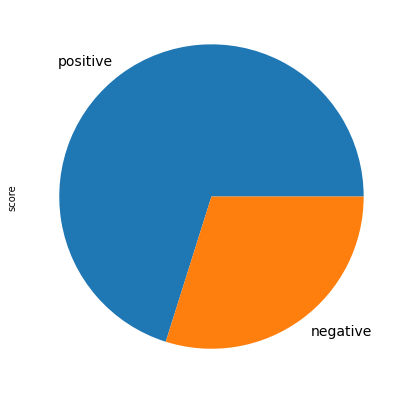

In [298]:
labled_df = SADataPreparation(cleaned_df).preprocess_data(True)
labled_df = labled_df[['clean_text', 'score']]
labled_df['score'].value_counts().plot.pie(figsize=(7,7), fontsize=14)